In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from datetime import datetime
from datetime import date
from datetime import timedelta
import yfinance as yf
import datetime
from workalendar.america import Brazil

In [2]:
start_date = '1994-03-01'
final_date = '2022-09-02'

In [3]:
df_ibov = pd.DataFrame()
df_ibov['IBOV'] = yf.download('^BVSP', start = start_date, end = final_date, interval = '1d')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
df_ibov.head()

,IBOV
Date,
1994-03-01,1073.300049
1994-03-02,1021.500000
1994-03-03,1045.800049
1994-03-04,1114.000000
1994-03-07,1193.900024


In [5]:
url_bcb = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
ipca = pd.read_json(url_bcb)
ipca['data'] = pd.to_datetime(ipca['data'], dayfirst = True)
ipca.rename(columns={'data': 'Date'}, inplace = True)
ipca.rename(columns={'valor': 'value'}, inplace = True)
ipca.set_index('Date', inplace = True)
ipca = ipca.loc[start_date:]

In [6]:
ipca = ipca / 100
ipca.head()

,value
Date,
1994-03-01,0.4275
1994-04-01,0.4268
1994-05-01,0.4403
1994-06-01,0.4743
1994-07-01,0.0684


In [7]:
df_ipca = pd.DataFrame()
df_ipca.index = pd.date_range(start_date, final_date, freq = 'D')
df_ipca.head()

""
1994-03-01
1994-03-02
1994-03-03
1994-03-04
1994-03-05


In [8]:
list_aux = []
for i in df_ipca.index:
    if len(str(i.month)) == 1:
        list_aux.append(f'{i.year}-0{i.month}')
    else:
        list_aux.append(f'{i.year}-{i.month}')

In [9]:
df_ipca['date_aux'] = list_aux
df_ipca.head()

,date_aux
1994-03-01,1994-03
1994-03-02,1994-03
1994-03-03,1994-03
1994-03-04,1994-03
1994-03-05,1994-03


In [10]:
list_ipca = []
for i in df_ipca['date_aux']:
    for index, row in ipca.iterrows():
        if i == index.strftime('%Y-%m'):
            list_ipca.append(row['value'])

In [11]:
df_ipca['IPCA'] = list_ipca

In [12]:
cal = Brazil()

ipca_working_day = {}

for dt, value in df_ipca.itertuples(index = False):
    
    month_int = int(dt.split('-')[1])
    month_str = dt.split('-')[1]
    year = int(dt.split('-')[0])
    
    if month_int == 1 or month_int == 3 or month_int == 5 or month_int == 7 or month_int == 8 or month_int == 10 or month_int == 12:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 31))
        ipca_working_day[f'{year}-{month_str}'] = ((1 + value)**(1/working_day)) - 1
        
    elif month_int == 2:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 28))
        ipca_working_day[f'{year}-{month_str}'] = ((1 + value)**(1/working_day)) - 1
        
    elif month_int == 4 or month_int == 6 or month_int == 9 or month_int == 11:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 30))
        ipca_working_day[f'{year}-{month_str}'] = ((1 + value)**(1/working_day)) - 1

In [13]:
df_ipca_working_day = pd.DataFrame(data = ipca_working_day.values(), index = ipca_working_day.keys(), 
                                   columns = ['IPCA_working_day'])

In [14]:
df_ipca_new = pd.merge(df_ipca, df_ipca_working_day, how = 'outer', left_on = 'date_aux', right_on = df_ipca_working_day.index)

In [15]:
df_ipca_new.index = df_ipca.index

In [16]:
df_ipca_new.head()

,date_aux,IPCA,IPCA_working_day
1994-03-01,1994-03,0.4275,0.01631
1994-03-02,1994-03,0.4275,0.01631
1994-03-03,1994-03,0.4275,0.01631
1994-03-04,1994-03,0.4275,0.01631
1994-03-05,1994-03,0.4275,0.01631


In [17]:
df_final = pd.merge(df_ibov, df_ipca_new, how = 'inner', left_index = True, right_index = True)
df_final['IPCA_working_day'] = df_final['IPCA_working_day'] + 1
df_final['IPCA_cumulative'] = df_final['IPCA_working_day'].cumprod()
df_final.head(25)

,IBOV,date_aux,IPCA,IPCA_working_day,IPCA_cumulative
1994-03-01,1073.300049,1994-03,0.4275,1.016310,1.016310
1994-03-02,1021.500000,1994-03,0.4275,1.016310,1.032886
1994-03-03,1045.800049,1994-03,0.4275,1.016310,1.049732
1994-03-04,1114.000000,1994-03,0.4275,1.016310,1.066853
1994-03-07,1193.900024,1994-03,0.4275,1.016310,1.084254
1994-03-08,1204.500000,1994-03,0.4275,1.016310,1.101938
1994-03-09,1260.199951,1994-03,0.4275,1.016310,1.119910
1994-03-10,1266.900024,1994-03,0.4275,1.016310,1.138176
1994-03-11,1268.699951,1994-03,0.4275,1.016310,1.156740
1994-03-14,1329.699951,1994-03,0.4275,1.016310,1.175606


In [18]:
ibov_daily = df_final.copy()
ibov_daily['IBOV'] = ibov_daily['IBOV'].pct_change()
ibov_daily = ibov_daily.iloc[1:]
ibov_daily['real_return'] = ((ibov_daily['IBOV'] + 1) / (ibov_daily['IPCA_working_day'])) - 1
ibov_daily.drop(columns = {'IBOV', 'date_aux', 'IPCA', 'IPCA_cumulative', 'IPCA_working_day'}, inplace = True)
ibov_daily.head()

,real_return
1994-03-02,-0.063536
1994-03-03,0.007359
1994-03-04,0.048118
1994-03-07,0.054524
1994-03-08,-0.007312


In [19]:
business_days = {'one_month': 21, 'two_months': 42, 'three_months': 63, 'four_months': 84, 'six_months': 126, 
                 'nine_months': 189, 'one_year': 252, 'two_years': 504, 'three_years': 756, 'four_years': 1008, 
                 'five_years': 1260, 'ten_years': 2520, 'fifteen_years': 3780, 'twenty_years': 5040, 'twenty_five_years': 6300,
                 'twenty_seven_years': 6804}

ibov = {}

for key, value in business_days.items():
      
    ibov[key] = df_final.copy()
    ibov[key]['IPCA_aux'] = ibov[key]['IPCA_cumulative'].shift(value + 1)
    ibov[key].replace(to_replace = ibov[key]['IPCA_aux'].iloc[value], value = 1, inplace = True)
    ibov[key]['IPCA_adjusted'] = ibov[key]['IPCA_cumulative'] / ibov[key]['IPCA_aux']
    ibov[key]['IBOV'] = ibov[key]['IBOV'].diff(periods = value) / ibov[key]['IBOV'].shift(value)
    ibov[key]['real_return'] = ((ibov[key]['IBOV'] + 1) / ibov[key]['IPCA_adjusted']) - 1
    ibov[key].drop(columns = {'IBOV', 'date_aux', 'IPCA', 'IPCA_aux', 'IPCA_cumulative', 'IPCA_adjusted', 'IPCA_working_day'}, 
                   inplace = True)
    ibov[key] = ibov[key].iloc[value:]

In [20]:
prop_return = {}

for key, value in ibov.items():

    prop_return[key] = round(100 * len(value[value['real_return'] > 0]) / len(value), 0)

In [21]:
periods_return = ['1 Day', '1 Month', '2 Months', '3 Months', '4 Months', '6 Months', '9 Months', '1 Year', '2 Years', 
                  '3 Years', '4 Years', '5 Years', '10 Years', '15 years', '20 years', '25 Years', '27 Years']

In [22]:
df_return = pd.DataFrame([prop_return])
df_return.insert(0, 'one_day', round(100 * len(ibov_daily[ibov_daily['real_return'] > 0]) / len(ibov_daily), 0))
df_return = df_return.T
df_return.rename(columns={0: '% of periods that earned a positive return'}, inplace = True)
df_return.insert(1, 'Holding Period', periods_return)
df_return

,% of periods that earned a positive return,Holding Period
one_day,52.0,1 Day
one_month,55.0,1 Month
two_months,55.0,2 Months
three_months,57.0,3 Months
four_months,58.0,4 Months
six_months,55.0,6 Months
nine_months,55.0,9 Months
one_year,55.0,1 Year
two_years,58.0,2 Years
three_years,66.0,3 Years


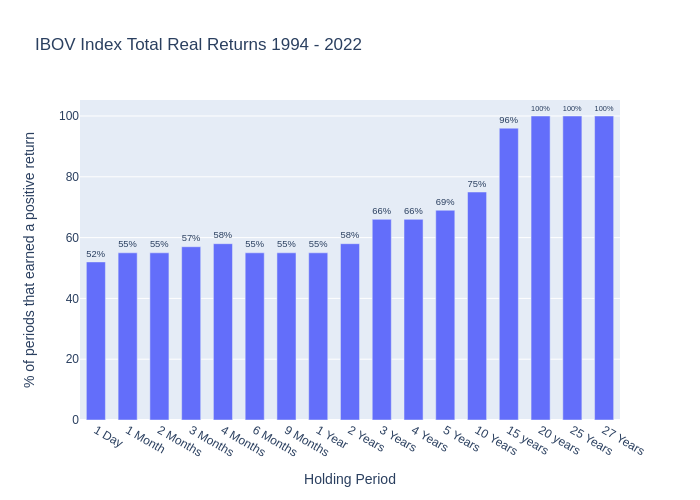

In [23]:
fig = px.bar(df_return, y= '% of periods that earned a positive return', x= 'Holding Period', text_auto='.2s',
            title="IBOV Index Total Real Returns 1994 - 2022", height=500)
fig.update_traces(textfont_size=12, textangle=0, texttemplate='%{y}%', textposition="outside", cliponaxis=False, width = 0.6)

fig.show('png')